In [2]:
import pandas as pd
import numpy as np


from sklearn.metrics import (f1_score, classification_report, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


In [3]:
df = pd.read_parquet("df_preprocessed.parquet")

train_cycles = ["A1", "B1", "B3"]
val_cycle    = "A2"
test_cycle   = "B2"

df_train = df[df["cycle_id"].isin(train_cycles)].copy()
df_val   = df[df["cycle_id"] == val_cycle].copy()
df_test  = df[df["cycle_id"] == test_cycle].copy()
print(df.keys())

feature_cols_all = [
    
    "delta_p_mean", 
    "delta_p_std",
    "delta_p_trend",
    "output_mean",
    "output_std",
    "output_trend",
    "active_pressure_fraction"

]

X_train = df_train[feature_cols_all]
X_val   = df_val[feature_cols_all]
X_test  = df_test[feature_cols_all]

y_train = df_train["label"]
y_val   = df_val["label"]
y_test  = df_test["label"]



Index(['pump_id', 'end_time', 'label', 'delta_p_mean', 'delta_p_std',
       'delta_p_trend', 'active_pressure_fraction', 'torque_median',
       'torque_std', 'torque_trend', 'output_mean', 'output_std',
       'output_trend', 'suction_mean', 'suction_std', 'discharge_mean',
       'discharge_std', 'flow_primary_mean', 'flow_total_mean',
       'tank_level_mean', 'tank_level_std', 'dm1_mean', 'dm1_std', 'dm2_mean',
       'dm2_std', 'dm3_mean', 'dm3_std', 'pc1_fraction', 'pc2_fraction',
       'pc3_fraction', 'cycle_id'],
      dtype='object')


In [4]:
from sklearn.impute import SimpleImputer

# LR-specific feature matrix

imputer = SimpleImputer(strategy="median")

X_train_lr = imputer.fit_transform(X_train)
X_val_lr = imputer.transform(X_val)
X_test_lr = imputer.transform(X_test)

y_train_lr = y_train.copy()
y_val_lr   = y_val.copy()
y_test_lr  = y_test.copy()



lr_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=500,
        class_weight="balanced", 
        solver="lbfgs",
        penalty='l2'
    ))
])

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(
    lr_pipe,
    param_grid_lr,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid_lr.fit(X_train_lr, y_train_lr)

print("Best LR params:", grid_lr.best_params_)

# evaluation
print("Validation performance:")
print(classification_report(y_val_lr, grid_lr.predict(X_val_lr)))
print("ROC-AUC:", roc_auc_score(y_val_lr, grid_lr.predict_proba(X_val_lr)[:,1]))


Best LR params: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Validation performance:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      3908
           1       0.16      1.00      0.27       168

    accuracy                           0.78      4076
   macro avg       0.58      0.88      0.57      4076
weighted avg       0.97      0.78      0.84      4076

ROC-AUC: 0.9792473924062973



Permutation Importance (sorted):
                    feature  importance_mean  importance_std
4                output_std         0.241066        0.006497
0              delta_p_mean         0.061425        0.002888
1               delta_p_std         0.018687        0.003483
5              output_trend         0.004386        0.001737
3               output_mean        -0.010107        0.001130
2             delta_p_trend        -0.012744        0.002456
6  active_pressure_fraction        -0.025209        0.003107


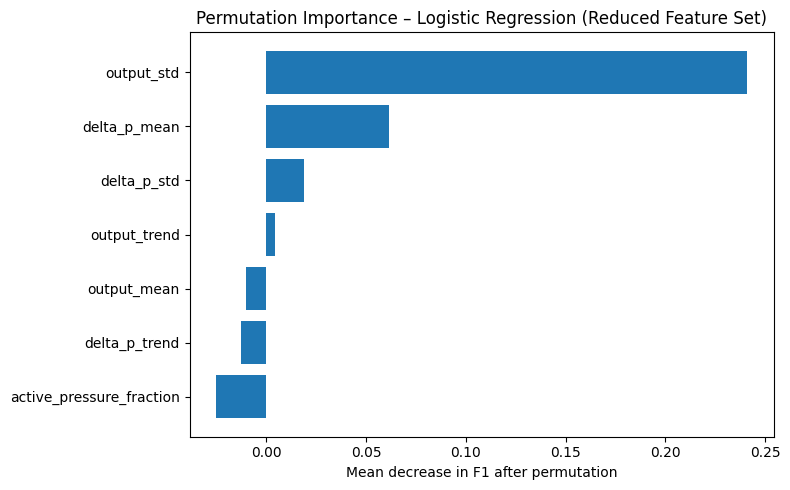

In [5]:
#permutation importance of log res (reduced):


# usebest estimator
best_lr_model = grid_lr.best_estimator_

# Compute permutation importance on validation set
perm_result = permutation_importance(
    best_lr_model,
    X_val_lr,          
    y_val_lr,
    n_repeats=50,
    scoring="f1",
    random_state=42
)

# importance table
importances_lr = pd.DataFrame({
    "feature": feature_cols_all,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std
}).sort_values("importance_mean", ascending=False)

print("\nPermutation Importance (sorted):")
print(importances_lr)

# plot
plt.figure(figsize=(8, 5))
plt.barh(importances_lr["feature"], importances_lr["importance_mean"])
plt.xlabel("Mean decrease in F1 after permutation")
plt.title("Permutation Importance – Logistic Regression (Reduced Feature Set)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()





In [6]:
#error analysis on test (log res reduced):
print("=== Logistic Regression — TEST CYCLE (B2) ===")
test_pred = grid_lr.predict(X_test_lr)
test_prob = grid_lr.predict_proba(X_test_lr)[:, 1]

print(classification_report(y_test_lr, test_pred))
print("ROC-AUC:", roc_auc_score(y_test_lr, test_prob))
print("Confusion matrix:\n", confusion_matrix(y_test_lr, test_pred))



=== Logistic Regression — TEST CYCLE (B2) ===
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3384
           1       0.02      0.05      0.03       168

    accuracy                           0.83      3552
   macro avg       0.48      0.46      0.46      3552
weighted avg       0.90      0.83      0.86      3552

ROC-AUC: 0.65133189800743
Confusion matrix:
 [[2924  460]
 [ 160    8]]


In [14]:
#compare line a vs b

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

def run_cross_line_full(train_lines, test_lines):
    df_train_CL = df[df["pump_id"].isin(train_lines)]
    df_test_CL  = df[df["pump_id"].isin(test_lines)]

    X_tr = df_train_CL[feature_cols_all]
    y_tr = df_train_CL["label"]

    X_te = df_test_CL[feature_cols_all]
    y_te = df_test_CL["label"]

    # impute + scale
    X_tr_imp = imputer.fit_transform(X_tr)
    X_te_imp = imputer.transform(X_te)

    # train LR
    lr_cl = Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(
            C=grid_lr.best_params_["clf__C"],
            max_iter=500,
            class_weight="balanced",
            solver="lbfgs",
            penalty="l2"
        ))
    ])
    lr_cl.fit(X_tr_imp, y_tr)

    preds = lr_cl.predict(X_te_imp)
    prob  = lr_cl.predict_proba(X_te_imp)[:, 1]

    # add confusion matrix
    cm = confusion_matrix(y_te, preds)
    
    report = classification_report(y_te, preds, output_dict=True)
    auc = roc_auc_score(y_te, prob)

    return cm, report, auc

# printing
cm_A_B, report_A_B, auc_A_B = run_cross_line_full(["A"], ["B"])
cm_B_A, report_B_A, auc_B_A = run_cross_line_full(["B"], ["A"])

print("cross-line")
print("\nA → B Confusion Matrix:\n", cm_A_B)
print("A → B F1:", report_A_B["1"]["f1-score"], "| AUC:", auc_A_B)

print("\nB → A Confusion Matrix:\n", cm_B_A)
print("B → A F1:", report_B_A["1"]["f1-score"], "| AUC:", auc_B_A)




cross-line

A → B Confusion Matrix:
 [[7210  626]
 [ 188  148]]
A → B F1: 0.26666666666666666 | AUC: 0.8056212626704586

B → A Confusion Matrix:
 [[6250 1586]
 [  33  303]]
B → A F1: 0.2723595505617977 | AUC: 0.9106470593597317


In [15]:
# check for low /high drymatter (1) based on mean

# Choose dry-matter variable from df (not part of feature_cols_all!)
dm_var = "dm1_mean"   # dm2_mean or dm3_mean also ok

# Extract dry matter values from the *test* cycle only
dm_values = df_test[dm_var]

# Median split into high and low dry matter subsets
dm_threshold = dm_values.mean()

df_lowDM  = df_test[df_test[dm_var] < dm_threshold]
df_highDM = df_test[df_test[dm_var] >= dm_threshold]

def evaluate_dm_subset(df_subset):
    # Extract reduced features
    X = df_subset[feature_cols_all]
    y = df_subset["label"]

    # scale same imputer from training
    X_imp = imputer.transform(X)

    # run tuned model
    preds = grid_lr.predict(X_imp)
    prob  = grid_lr.predict_proba(X_imp)[:,1]

    cm = confusion_matrix(y, preds)
    report = classification_report(y, preds, output_dict=True)
    auc = roc_auc_score(y, prob)

    return cm, report, auc

# printing
cm_low,  report_low,  auc_low  = evaluate_dm_subset(df_lowDM)
cm_high, report_high, auc_high = evaluate_dm_subset(df_highDM)

print("dry matter low")
print("F1:", report_low["1"]["f1-score"], "| AUC:", auc_low)
print("Confusion matrix:\n", cm_low)

print("dry matter low")
print("F1:", report_high["1"]["f1-score"], "| AUC:", auc_high)
print("Confusion matrix:\n", cm_high)


dry matter low
F1: 0.0 | AUC: nan
Confusion matrix:
 [[1462  280]
 [   0    0]]
dry matter low
F1: 0.0449438202247191 | AUC: 0.7643480656574444
Confusion matrix:
 [[1462  180]
 [ 160    8]]


/Users/teunlangenhuijsen/thesis_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/teunlangenhuijsen/thesis_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/teunlangenhuijsen/thesis_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/